# Setup

In [1]:
# ARCHITECTURE
!cat /etc/os-release
!lscpu | egrep 'Model name|Socket|Thread|NUMA|CPU\(s\)'
!nvidia-smi -q -i 0 | grep "Product Name"

NAME="Ubuntu"
VERSION="18.04.5 LTS (Bionic Beaver)"
ID=ubuntu
ID_LIKE=debian
PRETTY_NAME="Ubuntu 18.04.5 LTS"
VERSION_ID="18.04"
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
VERSION_CODENAME=bionic
UBUNTU_CODENAME=bionic
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Socket(s):           1
NUMA node(s):        1
Model name:          Intel(R) Xeon(R) CPU @ 2.00GHz
NUMA node0 CPU(s):   0,1
    Product Name                          : Tesla T4


In [2]:
import cv2, os, math, shutil, random, re, time
import xml.etree.ElementTree as ET
from collections import defaultdict
from datetime import datetime
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
from IPython.display import HTML
from base64 import b64encode
!pip install colour
from colour import Color

In [3]:
from google.colab import drive
drive.mount('/content/drive')
'''YOUR PROJECT DIRECTORY'''
path = '/content/drive/My Drive/AIRO/EAI/VP/EAI Project'
!ln -s /content/drive/My\ Drive/AIRO/EAI/VP/EAI\ Project /mydrive

Mounted at /content/drive


In [4]:
raw_data = path+'/KITTI/RAW_DATA'
object_data = path+'/KITTI/DATA_OBJECT'
darknet_path = path+'/yolov4/darknet'
data_path = darknet_path+'/data'
img_path = object_data+'/data_object_image_2/training/image_2'
label_path = object_data+'/data_object_label_2/training/label_2'
calib_path = object_data+'/data_object_calib/training/calib'
test_path = path+'/test'

**Working Folder**

In [6]:
raw_folder = '2011_09_26_drive_0015_sync'
!mkdir -p /mydrive/test/$raw_folder/plot/images/distance
!mkdir -p /mydrive/test/$raw_folder/plot/images/danger
!mkdir -p /mydrive/test/$raw_folder/data

### Utility

In [7]:
# show image with matplotlib
def imgshow(img, title=None, size=None):
  if type(img) == str:
    img = cv2.imread(img)
  plt.figure(figsize=size)
  if title is not None: plt.title(title)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

# convert left, top, right, bottom pixel in KITTI to yolov4 normalized coordinates
# <x_center> <y_center> <width> <height>
def convert_coordinates(coords, shape):
  x_center = (coords[0]+coords[2])/2/shape[0]
  y_center = (coords[1]+coords[3])/2/shape[1]
  width = (coords[2]-coords[0])/shape[0]
  height = (coords[3]-coords[1])/shape[1]
  return [x_center, y_center, width, height]

# line equation
def line_eq(p1, p2):
  m = (p2[1] - p1[1]) / (p2[0] - p1[0])
  b = p2[1] - m * p2[0]
  return m, b

# find the point of intersection of multiple lines
def multiple_line_intersection(lines):
  t1, t2 = np.zeros((2,2)), np.zeros((2,1))
  for l in lines:
    for x1,y1,x2,y2 in l:
      p1, p2 = np.array([[x1],[y1]]), np.array([[x2],[y2]])
      uv = np.array([[0,-1],[1,0]])@((p2-p1)/np.linalg.norm(p2-p1))
      t1 += uv@np.transpose(uv)
      t2 += uv@np.transpose(uv)@p1
  return np.linalg.inv(t1)@t2.reshape(2,)

def Rz(theta):
  return np.array([[math.cos(theta), -math.sin(theta), 0],
                   [math.sin(theta), math.cos(theta), 0],
                   [0, 0, 1]])
  
def Ry(theta):
  return np.array([[math.cos(theta), 0, math.sin(theta)],
                   [0, 1, 0],
                   [-math.sin(theta), 0, math.cos(theta)]])
  
# convert roll pitch yaw to rotation matrix
def RPY(roll=0, pitch=0, yaw=0):
  yaw_matrix = Rz(yaw)

  pitchMatrix = Ry(pitch)

  rollMatrix = np.array([[1, 0, 0],
                          [0, math.cos(roll), -math.sin(roll)],
                          [0, math.sin(roll), math.cos(roll)]])

  return yaw_matrix@pitchMatrix@rollMatrix

uppath = lambda _path, n: os.sep.join(_path.split(os.sep)[:-n])

# root mean squared error
def rmse(predictions, targets):
  return np.sqrt(((predictions - targets) ** 2).mean())

# reaction time + braking distance
def stopping_distance(v, t_r=1, mu=0.8, g=9.81):
  return v*t_r + v**2/(2*mu*g)

# covert number from a range to another
def remap(x, in_min, in_max, out_min, out_max):
  x = max(in_min, min(x, in_max)) 
  return (x - in_min) * (out_max - out_min) / (in_max - in_min) + out_min

# Dataset
http://www.cvlibs.net/datasets/kitti/


### folder structure

```
KITTI
|_DATA_OBJECT
  |_data_object_calib
    |_training
      |_calib
        |_000000.txt
        |_000001.txt
        |_xxxxxx.txt
    |_testing
      |_calib
        |_000000.txt
        |_000001.txt
        |_xxxxxx.txt
  |_data_object_image_2
    |_training
      |_image_2
        |_000000.png
        |_000001.png
        |_xxxxxx.png
    |_testing
      |_image_2
        |_000000.png
        |_000001.png
        |_xxxxxx.png
  |_data_object_label_2
    |_training
      |_label_2
        |_000000.txt
        |_000001.txt
        |_xxxxxx.txt

|_RAW_DATA
  |_2011_09_26
    |_2011_09_26_drive_0001_sync
      |_image_02
        |_data
          |_0000000000.png
          |_0000000001.png
          |_xxxxxxxxxx.png
        |_timestamps.txt
      |_oxts
        |_data
          |_0000000000.txt
          |_0000000001.txt
          |_xxxxxxxxxx.txt
        |_dataformat.txt
        |_timestamps.txt
      |_velodyne_points
        |_data
          |_0000000000.bin
          |_0000000001.bin
          |_xxxxxxxxxx.bin
        |_timestamps.txt
      |_tracklet_labels.xml
    |_2011_09_26_drive_0002_sync
    |_2011_09_26_drive_00xx_sync
    |_calib_cam_to_cam.txt
  |_2011_mm_gg
    |_2011_mm_gg_drive_0001_sync
      |_ ...
```


# Input Transformation

## Lane Detection

Shape = (375, 1242, 3)


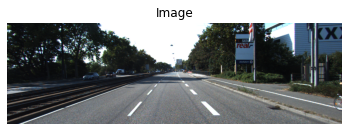

In [ ]:
img = cv2.imread(object_data+'/data_object_image_2/training/image_2/000004.png')
height, width = img.shape[:2]
print("Shape =", img.shape)

imgshow(img, 'Image')

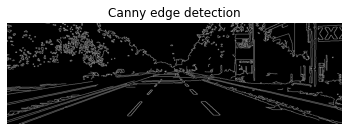

In [ ]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)    
blur = cv2.GaussianBlur(gray, (5, 5), 0) 
canny = cv2.Canny(blur, 50, 150)

imgshow(canny, 'Canny edge detection')

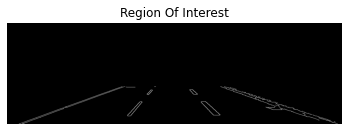

In [ ]:
# regione of interest points
roi_x1, roi_x2 = width/2-200, width/2+200
roi_y = height/2+50

# mask creation
polygons = np.int64([[(0, height), (roi_x1, roi_y), (roi_x2, roi_y), (width, height)]])
mask = np.zeros_like(canny)
cv2.fillPoly(mask, polygons, 255)

# Bitwise operation
roi = cv2.bitwise_and(canny, mask) 

imgshow(roi, 'Region Of Interest')

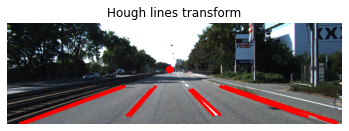

In [ ]:
line_img = np.copy(img)
# find lines
lines = cv2.HoughLinesP(roi, 1, np.pi/180, 80, minLineLength=40, maxLineGap=50)
# compute vanishing point
vp = multiple_line_intersection(lines)

# draw 
for l in lines: 
  for x1,y1,x2,y2 in l:
    cv2.line(line_img, (x1,y1), (x2,y2), (0,0,255), 10)
cv2.circle(line_img, tuple(vp.astype(int)), radius=1, color=(0,0,255), thickness=25)

imgshow(line_img, 'Hough lines transform')

## Inverse Perspective Mapping

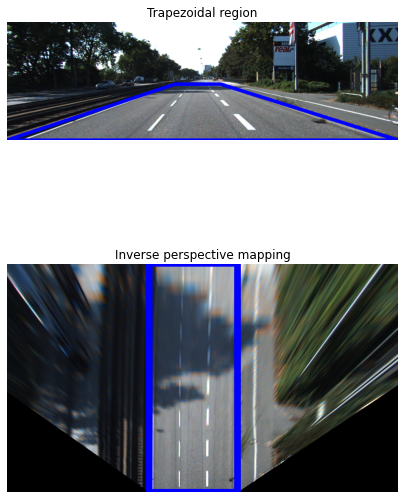

In [ ]:
# vanishing lines coefficients
m1, b1 = line_eq([0, height], vp)
m2, b2 = line_eq([width, height], vp)

# trapezoidal roi
t_y1 = t_y2 = height/2+10
t_x1, t_x2 = (t_y1-b1)/m1, (t_y2-b2)/m2
trapezoid = np.float32([[0,height], [t_x1,t_y1], [t_x2,t_y2], [width,height]])

# bird's eye view region
bev = np.float32([[t_x1,height], [t_x1,0], [t_x2,0], [t_x2,height]])

# find homography
H = cv2.getPerspectiveTransform(trapezoid, bev)
# apply homography
warp_img = cv2.warpPerspective(img, H, (width,height))

# draw 
t_img = np.copy(img)
cv2.line(t_img, tuple(trapezoid[0]), tuple(trapezoid[1]), (255,0,0), 10)
cv2.line(t_img, tuple(trapezoid[1]), tuple(trapezoid[2]), (255,0,0), 10)
cv2.line(t_img, tuple(trapezoid[2]), tuple(trapezoid[3]), (255,0,0), 10)
cv2.line(t_img, tuple(trapezoid[3]), tuple(trapezoid[0]), (255,0,0), 10)

cv2.line(warp_img, tuple(bev[0]), tuple(bev[1]), (255,0,0), 10)
cv2.line(warp_img, tuple(bev[1]), tuple(bev[2]), (255,0,0), 10)
cv2.line(warp_img, tuple(bev[2]), tuple(bev[3]), (255,0,0), 10)
cv2.line(warp_img, tuple(bev[3]), tuple(bev[0]), (255,0,0), 10)

# resize image 
warp_img = warp_img[0:height, 300:width-300]

f, axs = plt.subplots(2, 1, figsize=(7,10))
axs[0].set_title("Trapezoidal region")
axs[0].axis('off')
axs[0].imshow(cv2.cvtColor(t_img, cv2.COLOR_BGR2RGB))
axs[1].set_title("Inverse perspective mapping")
axs[1].axis('off')
axs[1].imshow(cv2.cvtColor(warp_img, cv2.COLOR_BGR2RGB))
plt.show()

## BEV Test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


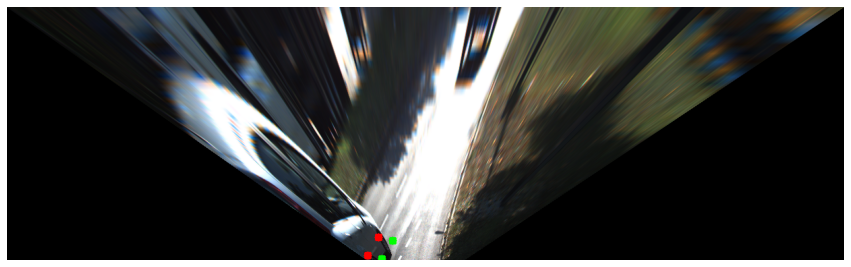

In [ ]:
image = cv2.imread(os.path.join(img_path, '000016.png'))
label = os.path.join(label_path, '000016.txt')
calib = os.path.join(calib_path, '000016.txt')
height, width, _ = image.shape
bev = cv2.warpPerspective(image, H, (width, height))

with open(label, 'r') as file:

  # camera matrix
  P = Calib.get_camera_matrix(calib)
  i = 0
  for line in file:
    if i < 3:
      i += 1
      continue
    arr = line.split()
    # width height
    w, l = float(arr[9]), float(arr[10])
    # center point
    x, y, z = float(arr[11]), float(arr[12]), float(arr[13])
    # orientation
    ry = float(arr[14])

    box = np.array([[l/2, l/2, -l/2, -l/2], 
                    [0.0, 0.0, 0.0, 0.0], 
                    [-w/2, w/2, -w/2, w/2]])
    
    t = np.array([[x], [y], [z+2]])    

    box = Ry(ry)@box + t
    box = np.vstack([box, np.ones((1,4))])
    
    x = H@P@box
    x /= x[2]
    x = np.transpose(x)[:,:-1]
    
    cv2.circle(bev, tuple(x[0].astype(int)), radius=1, color=(0,255,0), thickness=10)
    cv2.circle(bev, tuple(x[1].astype(int)), radius=1, color=(0,0,255), thickness=10)
    cv2.circle(bev, tuple(x[2].astype(int)), radius=1, color=(0,255,0), thickness=10)
    cv2.circle(bev, tuple(x[3].astype(int)), radius=1, color=(0,0,255), thickness=10)

    # left top
    x1 = np.array([[x-w/2],[y],[z+l/2],[1.]]) # point3d
    x1 = P@x1 # point2d
    x1 = H@x1 # point bev
    x1 /= x1[2]
    x1 = x1[:-1]
    
    # right bottom
    x2 = np.array([[x+w/2],[y],[z-l/2],[1.]]) # point3d
    x2 = P@x2 # point2d
    x2 = H@x2 # point bev
    x2 /= x2[2]
    x2 = x2[:-1]

    #cv2.rectangle(bev, tuple(x1.astype(int)), tuple(x2.astype(int)), color=(0,255,0), thickness=2)
    break
imgshow(bev, size=(15,10))

In [ ]:
# create video sequence
image_folder = os.path.join(raw_data, raw_folder[0:10], raw_folder, 'image_02','data')

images = [cv2.imread(os.path.join(image_folder, img)) for img in sorted(os.listdir(image_folder)) if img.endswith(".png")]
height, width, _ = images[0].shape
images = [cv2.warpPerspective(img, H,(width, height)) for img in images]
video = cv2.VideoWriter(os.path.join(test_path, raw_folder,'bev.avi'), 0, 10, (width, height))

for img in images: video.write(img)
video.release()

# convert video from avi to mp4
%cd /mydrive/test/$raw_folder
!ffmpeg -y -i bev.avi bev.mp4 > /dev/null 2>&1
!rm bev.avi

In [ ]:
# show video
from IPython.display import HTML
from base64 import b64encode
mp4 = open(os.path.join(test_path, raw_folder,'bev.mp4'),'rb').read()
decoded_vid = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f'<video width="750" height="300" controls><source src={decoded_vid} type="video/mp4"><video/>')

Output hidden; open in https://colab.research.google.com to view.

# Feature Detection

## YOLOv4

### darknet

In [ ]:
# clone darknet
# change makefile to have GPU and OPENCV enabled
# also set CUDNN, CUDNN_HALF and LIBSO to 1
# build
# downloads convolutional layers weights
%%shell
if [[ -d /mydrive/yolov4/darknet ]]
then 
  chmod +x /mydrive/yolov4/darknet/darknet
  echo "The yolov4/darknet directory exists."
else
  mkdir -p /mydrive/yolov4
  cd /mydrive/yolov4
  git clone https://github.com/AlexeyAB/darknet
  cd darknet/
  sed -i 's/OPENCV=0/OPENCV=1/' Makefile
  sed -i 's/GPU=0/GPU=1/' Makefile
  sed -i 's/CUDNN=0/CUDNN=1/' Makefile
  sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
  sed -i 's/LIBSO=0/LIBSO=1/' Makefile
  make > /dev/null 2>&1
  !wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137
fi

The yolov4/darknet directory exists.


In [ ]:
'''#build on cpu!!
%%shell
cd /mydrive/yolov4/darknet
sed -i 's/GPU=1/GPU=0/' Makefile
sed -i 's/CUDNN=1/CUDNN=0/' Makefile
sed -i 's/CUDNN_HALF=1/CUDNN_HALF=0/' Makefile
make > /dev/null 2>&1'''

Follow steps by https://github.com/AlexeyAB/darknet

1.   Create and modify cfg file yolo-obj.data in ``yolov4/darknet/cfg/``
2.   Create obj.data and obj.names in ``yolov4/darknet/data/``

In [ ]:
# copy .cfg file
%%shell
if [[ -f /mydrive/yolov4/yolov4-obj.cfg ]]
then 
  echo "The yolov4/yolov4-obj.cfg file exists."
else
  cp cfg/yolov4-custom.cfg /mydrive/yolov4/yolov4-obj.cfg
fi

The yolov4/yolov4-obj.cfg file exists.


**yolov4-obj.cfg**
```
batch=64
subdivision=16
width=416
height=416
max_batches=14000 (#classes*2000)
steps=11200,12600 (80%max_batches,90%max_batches)
classes=7 (in the three yolo layers)
filters=36 ([#classes+5]*3 in the three conv layers before yolo)
```

In [ ]:
# upload the custom .cfg
!cp /mydrive/yolov4/yolov4-obj.cfg /mydrive/yolov4/darknet/cfg
!echo "The yolov4/yolov4-obj.cfg file has been moved."

The yolov4/yolov4-obj.cfg file has been moved.


In [ ]:
# create the obj.names and obj.data files
%%shell
if [[ -f /mydrive/yolov4/obj.names && -f /mydrive/yolov4/obj.data ]]
then 
  echo "The yolov4/obj.names and yolov4/obj.data files exist."
else
  touch /mydrive/yolov4/obj.names.txt
  touch /mydrive/yolov4/obj.data.txt
fi

The yolov4/obj.names and yolov4/obj.data files exist.


**obj.data**
```
classes = 7
train  = data/train.txt
valid  = data/valid.txt
names = data/obj.names
backup = backup
```

**obj.names**
```
Car
Van
Truck
Pedestrian
Cyclist
Tram
Misc
```

In [ ]:
# upload the obj.names and obj.data files
%%shell
if [[ -f /mydrive/yolov4/obj.names.txt && -f /mydrive/yolov4/obj.data.txt ]]
then
  mv /mydrive/yolov4/obj.names.txt /mydrive/yolov4/obj.names
  mv /mydrive/yolov4/obj.data.txt /mydrive/yolov4/obj.data 
fi
cp /mydrive/yolov4/obj.names /mydrive/yolov4/darknet/data
cp /mydrive/yolov4/obj.data  /mydrive/yolov4/darknet/data
echo "The yolov4/obj.names and yolov4/obj.data files have been moved."

The yolov4/obj.names and yolov4/obj.data files have been moved.


### dataset

In [ ]:
# create train and valid folders
%%shell
if ! [[ -d /mydrive/yolov4/darknet/data/train && -d /mydrive/yolov4/darknet/data/valid ]]
then
  mkdir -p /mydrive/yolov4/darknet/data/train
  mkdir -p /mydrive/yolov4/darknet/data/valid
  echo "The train directory has been created."
  echo "The valid directory has been created."
else
  echo "The train and valid directories already exist."
fi

The train and valid directories already exist.


In [ ]:
# classes dictionary
import os

classes = {}
with open(os.path.join(path, 'yolov4', 'obj.names'), 'r') as file:
  for num, line in enumerate(file):
    line = line.rstrip("\n")
    classes[line] = num
  file.close()
print(classes)

{'Car': 0, 'Van': 1, 'Truck': 2, 'Pedestrian': 3, 'Cyclist': 4, 'Tram': 5, 'Misc': 6}


In [ ]:
# divide training and validation (90/10)
# create yolo-like labels
# generate train.txt and valid.txt
# move to into darknet workspace

if True: print('Change True to False')
else:
  rand = list(zip(sorted(os.listdir(img_path)), sorted(os.listdir(label_path)))) 
  size = len(rand)
  train_size = int(size*0.9)
  random.shuffle(rand)
  dst = 'train'

  with open(os.path.join(data_path, 'train.txt'), 'w') as tfile, open(os.path.join(data_path, 'valid.txt'), 'w') as vfile:
    for i, (img, label) in enumerate(tqdm(rand)): 
      if i < train_size:
        tfile.write('data/train/'+img+'\n')
      else:
        if dst == 'train': dst = 'valid'
        vfile.write('data/valid/'+img+'\n')
      
      # copy image from object data to darknet data
      im = cv2.imread(os.path.join(img_path, img))
      height, width, _ = im.shape
      shutil.copyfile(os.path.join(img_path, img), os.path.join(data_path, dst, img))

      # write txt label file < class yolo_coordinates >
      with open(os.path.join(label_path, label), 'r') as rfile, open(os.path.join(data_path, dst, label), 'w') as wfile:
        for line in rfile:
          arr = line.split()
          if arr[0] == 'DontCare': continue
          if arr[0] == 'Person_sitting': arr[0] = 'Pedestrian'
          coords = [float(i) for i in arr[4:8]]
          yolo_coords = convert_coordinates(coords, (width, height))
          text = str(classes[arr[0]]) + " " + " ".join([str(i) for i in yolo_coords]) + '\n'
          wfile.write(text)
        rfile.close()
        wfile.close()
      break
    tfile.close()
    vfile.close()

Change True to False


### training

In [ ]:
%cd /mydrive/yolov4/darknet
!sed -i 's/batch=1/batch=64/' cfg/yolov4-obj.cfg
!sed -i 's/subdivisions=1/subdivisions=16/' cfg/yolov4-obj.cfg
!sed -i 's/width=1248/width=416/' cfg/yolov4-obj.cfg
!sed -i 's/height=384/height=416/' cfg/yolov4-obj.cfg
!./darknet detector train data/obj.data cfg/yolov4-obj.cfg yolov4.conv.137 -dont_show -map
#!./darknet detector train data/obj.data cfg/yolov4-obj.cfg backup/yolov4-obj_last.weights -dont_show -map

/content/drive/.shortcut-targets-by-id/193iBf7rKKvpqlfxhY0uSzOpHewcW0V8-/EAI Project/yolov4/darknet


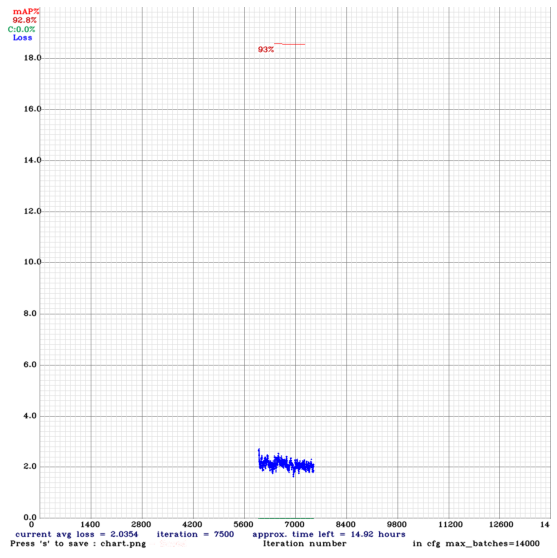

In [ ]:
# avg loss and map chart
%cd /mydrive/yolov4/darknet
imgshow('chart.png', size=(10,10))

## Python Wrapper

In [ ]:
# need to set our custom cfg to test mode 
%cd /mydrive/yolov4/darknet
!sed -i 's/batch=64/batch=1/' cfg/yolov4-obj.cfg
!sed -i 's/subdivisions=16/subdivisions=1/' cfg/yolov4-obj.cfg
!sed -i 's/width=416/width=1248/' cfg/yolov4-obj.cfg
!sed -i 's/height=416/height=384/' cfg/yolov4-obj.cfg

/content


In [8]:
os.chdir(darknet_path)
import darknet

class YOLOV4:

  def __init__(self):
    
    self.class_colors = {'Car': (0, 0, 255),
                         'Cyclist': (255, 255, 0),
                         'Misc': (59, 200, 164),
                         'Pedestrian': (255, 51, 255),
                         'Tram': (0, 0, 0),
                         'Truck': (255, 0, 0),
                         'Van': (0, 255, 0)}

    self.network, self.class_names, _ = darknet.load_network(
        'cfg/yolov4-obj.cfg',
        'data/obj.data',
        'backup/yolov4-obj_last.weights',
    )
  
  def image_detection(self, img, thresh=0.5, draw=False):
    height, width = img.shape[:2]
    darknet_image = darknet.make_image(width, height, 3)
    darknet.copy_image_from_bytes(darknet_image, img.tobytes())
    detections = darknet.detect_image(self.network, self.class_names, darknet_image, thresh=thresh)
    darknet.free_image(darknet_image)
    if draw:
      image = darknet.draw_boxes(detections, img.copy(), self.class_colors)
      return image, [(x[0], x[1], darknet.bbox2points(x[2])) for x in detections]
    else:
      return [(x[0], x[1], darknet.bbox2points(x[2])) for x in detections]

In [ ]:
yolov4 = YOLOV4()

### testing

**Test on single Image**

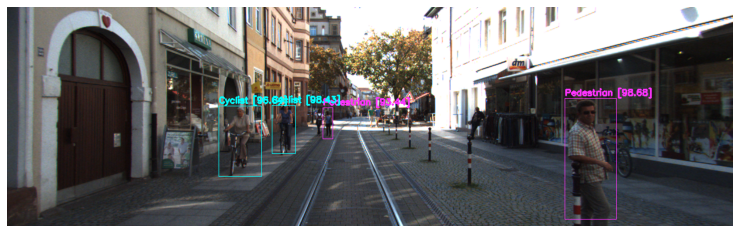

In [ ]:
img = cv2.imread(os.path.join(raw_data, raw_folder[0:10], raw_folder, 'image_02','data', '0000000301.png'))
img, _ = yolov4.image_detection(img, thresh=0.7, draw=True)
imgshow(img, size=(13,8))

**Test on Video sequence**

In [ ]:
# create video sequence
image_folder = os.path.join(raw_data, raw_folder[0:10], raw_folder, 'image_02','data')
images = [cv2.imread(os.path.join(image_folder, img)) for img in sorted(os.listdir(image_folder)) if img.endswith(".png")]
height, width, _ = images[0].shape
video = cv2.VideoWriter(os.path.join(test_path, raw_folder, 'video.avi'), 0, 10, (width,height))

for img in images: video.write(img)
video.release()

In [ ]:
# predict on video sequence
img = cv2.imread(os.path.join(raw_data, raw_folder[0:10], raw_folder, 'image_02','data', '0000000000.png'))
height, width, _ = img.shape
video_in = os.path.join(test_path, raw_folder, 'video.avi')
video_out = cv2.VideoWriter(os.path.join(test_path, raw_folder, 'detection.avi'), 0, 10, (width,height))

cap = cv2.VideoCapture(video_in)

# Read until video is completed
while(cap.isOpened()):

  # Capture frame-by-frame
  ret, frame = cap.read()
  
  if ret == False: break

  img, _ = yolov4.image_detection(frame, thresh=0.7, draw=True)
  video_out.write(img)  

video_out.release()

# convert video from avi to mp4
%cd /mydrive/test/$raw_folder
!ffmpeg -y -i detection.avi detection.mp4 > /dev/null 2>&1
!rm detection.avi

In [ ]:
# show video
mp4 = open(os.path.join(test_path, raw_folder, 'detection.mp4'),'rb').read()
decoded_vid = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f'<video width="750" height="300" controls><source src={decoded_vid} type="video/mp4"><video/>')

Output hidden; open in https://colab.research.google.com to view.

# Distance Estimation
compute distance from 1 to 1 correspondances

[u v 1] = P [X 0 Z 1]

## Calibration Data

In [9]:
class Calib:

  def __init__(self, path, translationY=1.65, translationZ=0):
    self.path = path
    translation = np.vstack([np.hstack([np.eye(3,3), np.array([[0.], [translationY], [translationZ]])]), np.array([0., 0., 0., 1.])])
    self.P = self.camera_matrix(path)@translation
    self.P_y0 = np.delete(self.P, np.s_[1:2], axis=1)
    self.imu2velo = self.read_file(path, 'calib_imu_to_velo.txt')
    self.velo2cam = self.read_file(path, 'calib_velo_to_cam.txt')

  def camera_matrix(self, path):
    with open(os.path.join(path, 'calib_cam_to_cam.txt'), 'r') as file:
      for line in file:
        arr = line.split(':')
        if arr[0] == 'P_rect_02': return np.fromstring(arr[1], sep=" ").reshape(3,4)

  def read_file(self, path, file):
    R = np.empty((3,3))
    T = np.empty((1,3))
    with open(os.path.join(path, file), 'r') as file:
      for line in file:
        arr = line.split(':')
        if arr[0] == 'calib_time': continue 
        if arr[0] == 'R': R = np.fromstring(arr[1], sep=" ").reshape(3,3)
        if arr[0] == 'T': T = np.fromstring(arr[1], sep=" ").reshape(3,1)
    return {'R': R, 'T': T}

  @staticmethod
  def get_camera_matrix(path, camera='2'):
    with open(os.path.join(path), 'r') as file:
      for line in file:
        arr = line.split(':')
        if arr[0] == 'P'+camera: return np.fromstring(arr[1], sep=" ").reshape(3,4)

In [ ]:
calib = Calib(raw_data+'/2011_09_26')

**2D Correspondance**

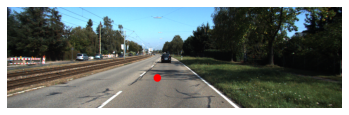

[[-1.]
 [10.]
 [ 1.]]


In [ ]:
img = cv2.imread(os.path.join(raw_data, raw_folder[0:10], raw_folder, 'image_02','data', '0000000000.png'))

# define a random 3d point in the image
point3d = np.array([[-1.],[0.],[10.],[1.]])

#point2d = projection matrix * point3d
point2d = calib.P@point3d
point2d /= point2d[2] # homogeneous normalization

imgshow(cv2.circle(img.copy(), tuple(point2d[:-1].astype(int)), radius=1, color=(0,0,255), thickness=25))

# compute correspondance
point3d = np.linalg.inv(calib.P_y0)@point2d
point3d /= point3d[2]
print(point3d)

## Detected Object

In [ ]:
class Detection:

  def __init__(self, path, detector):
    self.name = path[path.find('sync')-22:path.find('sync')+4]
    self.detections = [] # data structure
    self.classes = {'Car': 0, 'Van': 1, 'Truck': 2, 'Pedestrian': 3, 'Cyclist': 4, 'Tram': 5, 'Misc': 6}
    self.detector = detector
    self.__parse_file(path)

  def __iter__(self): # iter all items no matter the frame
    return iter(self.detections)

  def __getitem__(self, i): # get items at frame i
    return self.detections[i]

  def __len__(self):
    return len(self.detections)
  
  def __parse_file(self, path):
    # frame count
    n_frame = 0
    # video
    cap = cv2.VideoCapture(path)
    # Read until video is completed
    while(cap.isOpened()):
      # Capture frame-by-frame
      ret, frame = cap.read()
      if ret == False: break

      elements = []
      detection = self.detector.image_detection(frame, thresh=0.7)
      
      for d in detection:
        
        name, percentage, box = d
        box2d = {'left_x': box[0], 
                 'top_y': box[1], 
                 'width': box[2]-box[0], 
                 'height': box[3]-box[1]}

        element = {'frame': n_frame, 
                  'box2d': box2d,
                  'class': name,
                  '%': float(percentage)/100,
                  'id': None}

        elements.append(element)
      
      n_frame += 1
      self.detections.append(elements)

detection_path = os.path.join(test_path, raw_folder, 'video.avi')
detections = Detection(detection_path, yolov4)

In [10]:
#image coordinates to worlds coordinates
def img2world(box2d, calib):
  w, h = box2d['width'], box2d['height']
  left_x, top_y = box2d['left_x'], box2d['top_y']

  x1 = np.array([[left_x], [top_y+h], [1]]) # image borders
  x1_2d = np.linalg.inv(calib)@x1 # 2d point
  x1_2d /= x1_2d[2]

  x2 = np.array([[left_x+w], [top_y+h], [1]])
  x2_2d = np.linalg.inv(calib)@x2
  x2_2d /= x2_2d[2]    
  
  return x1_2d[:-1], x2_2d[:-1] #remove homogeneous coordinate [2]

## Ground Thruth

**tracklets.xml**

In [ ]:
class Tracklet:

  def __init__(self, path):
    self.name = path[path.find('sync')-22:path.find('sync')+4]
    self.n_objects = None # number of detected object in the video
    self.tracklets = defaultdict(list) # data structure
    self.__parse_xml(path)
    
  def __iter__(self): # iter all items no matter the frame
    return iter(self.tracklets.values())

  def __getitem__(self, i): # get items at frame i
    return self.tracklets[i]

  def __len__(self):
    return len(self.tracklets)
  
  def __parse_xml(self, path):
    elements = []
    tree = ET.parse(path)
    root = tree.getroot()
    id = 0
    for item in root[0]:
      if item.tag == 'count': 
        self.n_objects = int(root[0][0].text)
        continue
      elif item.tag == 'item_version': continue
      
      element = {}
      element['box3d'] = {}
      frame = 0
      for subitem in item:
        if subitem.tag == 'objectType': element['class'] = subitem.text
        elif subitem.tag == 'h': element['box3d']['h'] = float(subitem.text)
        elif subitem.tag == 'w': element['box3d']['w'] = float(subitem.text)
        elif subitem.tag == 'l': element['box3d']['l'] = float(subitem.text)
        elif subitem.tag == 'first_frame': frame = int(subitem.text)
        elif subitem.tag == 'poses':
          element['id'] = id
          for count, pose in enumerate(subitem):
            if pose.tag == 'item':
              element['frame'] = frame
              element['pose'] = {pose[i].tag:float(pose[i].text) for i in range(6)}
              frame += 1
              elements.append(element.copy())
          id += 1
    
    for track in sorted(elements, key=lambda k: k['frame']):
      self.tracklets[track['frame']].append(track)

tracklet_path = os.path.join(raw_data, raw_folder[0:10], raw_folder, 'tracklet_labels.xml')
tracklets = Tracklet(tracklet_path)

**test**

In [ ]:
%cd /mydrive/test/$detections.name/

assert len(detections) == len(tracklets)

for i in range(len(detections)):

  lat_lim = 10
  long_lim = 50

  plt.figure(figsize=(4,8))
  plt.grid(True)
  plt.xlim([-lat_lim, lat_lim])
  plt.ylim([0, long_lim])
  plt.xlabel('lateral dist. (m)')
  plt.ylabel('longitudinal dist. (m)')
  plt.xticks(np.arange(-lat_lim, lat_lim+1, 5))
  plt.yticks(np.arange(0, long_lim+1, 5))

  # predictions
  for detection in detections[i]:
    
    x1, x2 = img2world(detection['box2d'], calib.P_y0)
    t_long, t_lat = x1[1], (x1[0]+x2[0])/2
    
    if abs(t_lat) > lat_lim or t_long > long_lim: continue # plot limits

    # display detection
    plt.plot((x1[0],x2[0]), (x1[1],x2[1]), color='red', linewidth=5)
    # display distance
    plt.text(x2[0]+0.5, x1[1]-0.25, str(round(x1[1][0], 2))+'m', color='red', fontsize=12)
    # display class
    plt.text(x1[0]-0.25, x1[1]+1, detection['class'], color='red', fontsize=12)

  # ground thruth
  for track in tracklets[i]:
    
    t_long, t_lat = track['pose']['tx'], track['pose']['ty']

    if abs(t_lat) > lat_lim or t_long > long_lim: continue # plot limits

    w, l = track['box3d']['w'], track['box3d']['l']
    rz = track['pose']['rz']

    box3d = np.array([[-l/2, -l/2], 
                      [+w/2, -w/2],
                      [0.0, 0.0]])
    t = np.array([[t_long], [t_lat], [0.0]])
    
    border3d_velo = Rz(rz)@box3d + t # object to velo
    border3d_cam = calib.velo2cam['R']@border3d_velo + calib.velo2cam['T'] # velo to cam
    border2d = np.delete(border3d_cam, np.s_[1:2], axis=0) # y axis = 0

    x1, x2 = border2d[1]
    if border2d[0][0] < border2d[0][1]:
      y1, y2 = border2d[0]
    else:
      y2, y1 = border2d[0]
    
    # display detection
    plt.plot((y1,y2), (x1,x2), color='blue', linewidth=5)
    # display distance
    plt.text(y1+2.5, x1-0.25, str(round(t_long, 2))+'m', color='blue', fontsize=12)
    # display class
    plt.text(y1-0.25, x1+1, track['class'], color='blue', fontsize=12)

  label_a = mpatches.Patch(color='red', label='Predicted')
  label_b = mpatches.Patch(color='blue', label='Ground Thruth')
  plt.legend(handles=[label_a, label_b], title='Distance', loc='upper center', bbox_to_anchor=(0.5, 1.15), fancybox=True)
  plt.savefig('plot/images/distance/plot_frame{0:03}.png'.format(i))
  plt.clf()
  plt.close()

plots = [cv2.imread('plot/images/distance/'+img) for img in sorted(os.listdir('plot/images/distance'))]
height, width, _ = plots[0].shape
video = cv2.VideoWriter('plot/distance_plot.avi', 0, 10, (width, height))

for plot in plots: video.write(plot)
video.release()

# convert video from avi to mp4
!ffmpeg -y -i plot/distance_plot.avi plot/distance_plot.mp4 > /dev/null 2>&1
!rm plot/distance_plot.avi

/content/drive/.shortcut-targets-by-id/193iBf7rKKvpqlfxhY0uSzOpHewcW0V8-/EAI Project/test/2011_09_26_drive_0091_sync


**display**

In [ ]:
# show video
from IPython.display import HTML
from base64 import b64encode
mp4 = open(os.path.join(test_path, raw_folder, 'plot/distance_plot.mp4'),'rb').read()
decoded_vid = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f'<video width="300" height="600" controls><source src={decoded_vid} type="video/mp4"><video/>')

## Performance

In [ ]:
# create arrays with single detections and ground thuth of the front car for measure the performance
assert len(detections) == len(tracklets)
det_dict = defaultdict(list)
gt_dict = defaultdict(list)

for i in range(len(detections)):
  
  for detection in detections[i]:
    frame = detection['frame']
    
    x1_2d, x2_2d = img2world(detection['box2d'], calib.P_y0)
    
    tx, ty = x1_2d[1][0], (x1_2d[0][0]+x2_2d[0][0])/2
  
    if abs(ty) < 1.5: # meter distance from the center of the camera to the road 
      det_dict[frame].append({'tx': tx, 'ty': ty, 'frame': frame})

  for track in tracklets[i]:
    frame = track['frame']
    tx, ty = track['pose']['tx'], track['pose']['ty']
    w, l = track['box3d']['w'], track['box3d']['l']
    rz = track['pose']['rz']

    box3d = np.array([[-l/2, -l/2], 
                      [+w/2, -w/2],
                      [0.0, 0.0]])
    t = np.array([[tx], [ty], [0.0]])
    
    border3d_velo = Rz(rz)@box3d + t # object to velo
    border3d_cam = calib.velo2cam['R']@border3d_velo + calib.velo2cam['T'] # velo to cam
    border2d = np.delete(border3d_cam, np.s_[1:2], axis=0) # y axis = 0
    
    ty = (border2d[0][0]+border2d[0][1])/2

    if abs(ty) < 1.5:
      gt_dict[frame].append({'tx': tx, 'ty': ty, 'frame': frame})

# eliminate duplicated
for k in det_dict.keys():
  if len(det_dict[k]) > 1:
    for el in det_dict[k]:
      if abs(det_dict[k-1][0]['tx']-el['tx']) > 1:
        det_dict[k].remove(el)
  if len(gt_dict[k]) > 1:
    for el in gt_dict[k]:
      if abs(gt_dict[k-1][0]['tx']-el['tx']) > 1:
        gt_dict[k].remove(el)

det_arr = [v[0] for _,v in det_dict.items()]
gt_arr = [v[0] for _,v in gt_dict.items()]

assert len(gt_arr) == len(det_arr)

Compute RMSE

In [ ]:
# longitudinal (m)
p = np.array([x['tx'] for x in det_arr])
t = np.array([x['tx'] for x in gt_arr])
rmse_x = rmse(p,t)
print('longitudinal RMSE: {}'.format(rmse_x))

# lateral (m)
p = np.array([x['ty'] for x in det_arr])
t = np.array([x['ty'] for x in gt_arr])
rmse_y = rmse(p,t)
print('lateral RMSE: {}'.format(rmse_y))

longitudinal RMSE: 3.025139923283791
lateral RMSE: 0.1512065385600208


# Danger Evaluation

### Inertial Measurement Unit Data

In [11]:
class IMU: #inertial measurement unit data

  def __init__(self, path):
    self.name = path[path.find('sync')-22:path.find('sync')+4]
    self.oxts = [] # data structure
    self.__time_format = "%Y-%m-%d %H:%M:%S.%f"
    self.__parse_file(path)
    
  def __iter__(self): # iter all items no matter the frame
    return iter(self.oxts)

  def __getitem__(self, i): # get items at frame i
    return self.oxts[i]

  def __len__(self):
    return len(self.oxts)

  def __parse_file(self, path):
    oxts = []
    timestamps = []
    
    with open(uppath(path, 1) + '/dataformat.txt', 'r') as f:
      for line in f:
        oxts.append(line.split(':')[0])
    
    with open(uppath(path, 1) + '/timestamps.txt', 'r') as f:
      for line in f:
        timestamps.append(line.strip()[:-3])
    
    files = sorted(os.listdir(path))
    for i, file in enumerate(files):
      with open(os.path.join(path, file), 'r') as f:
        arr = f.readline().strip().split(' ')
        element = {'frame': int(file[:-4]), 
                   'timestamp': datetime.strptime(timestamps[i], self.__time_format).timestamp()}
        for i in range(len(oxts)):
          element[oxts[i]] = arr[i]
      self.oxts.append(element)

In [ ]:
oxts_path = os.path.join(raw_data, raw_folder[0:10], raw_folder, 'oxts/data')
oxts = IMU(oxts_path)

## Zone Subdivision


*   **Danger zone**: evaluate stopping distance
*   **Attention zone**: check whether the veichile is getting closer or further away to the danger zone
*   **Safe zone**: evaluate euclidean distance

```
Dangerousness = range(min=0, max=10, zone_criterion * class_vulnerability * zone_coefficient)
```

## Object Tracking

In [12]:
class Tracker:

  def __init__(self, x_dist, y_dist, clean_f):
    # Store the positions of the objects
    self.points = {}
    # Keep the count of the IDs
    # each time a new object id detected, the count will increase by one
    self.id_count = 0
    # dist offsets (m)
    self.x_dist = x_dist
    self.y_dist = y_dist
    # clean dictionary each n frames
    self.clean_f = clean_f
    # keep count of frames
    self.frame = 0
    # keep track of ids
    self.current_obj_ids = []
    self.previous_obj_ids = []

  def update(self, obj):

    x, y = obj
    same_object = False
    
    for id, pt in self.points.items(): 

      x_dist = abs(x - pt[0])
      y_dist = abs(y - pt[1])
      
      if x_dist < self.x_dist and y_dist < self.y_dist:
        self.points[id] = (x, y)
        obj_id = [x, y, id]
        same_object = True
        break
    
    # New object is detected, we assign the ID to that object
    if not same_object:
      self.points[self.id_count] = (x, y)
      obj_id = [x, y, self.id_count]
      self.id_count += 1

    # current frame obj ids
    self.current_obj_ids.append(obj_id)

    # return id
    return obj_id[2]
  
  def clean(self):
    # update frame
    self.frame += 1

    # Clean the dictionary by points to remove IDS not used anymore
    if self.frame % self.clean_f == 0:
      new_points = {}
      for obj_id in self.current_obj_ids:
        _, _, id = obj_id
        pt = self.points[id]
        new_points[id] = pt
      
      # Update dictionary with IDs not used removed
      self.points = new_points.copy()
    
    # update current and previous ids
    self.previous_obj_ids = {x[2]:x[0:2] for x in self.current_obj_ids}
    self.current_obj_ids = []

**test**

In [ ]:
detection_path = os.path.join(test_path, raw_folder, 'detection.mp4')
cap = cv2.VideoCapture(detection_path)

# tracking
tracker = Tracker(x_dist=6, y_dist=1, clean_f=3)

frames = []

for i in range(len(detections)):
    # Capture frame-by-frame
    _, frame = cap.read()
    
    for obj in detections[i]:
      box2d = obj['box2d']
      x, y = box2d['left_x'], box2d['top_y'] 
      x1, x2 = img2world(box2d, calib.P_y0)  
      t_long, t_lat = x1[1][0], (x1[0][0]+x2[0][0])/2
      #if abs(t_lat) > 10: continue # skip out of zones
      id = tracker.update([t_long, t_lat])
      obj['id'] = id
      cv2.putText(frame, str(id), (x, y - 15), cv2.FONT_HERSHEY_PLAIN, 2, (255, 255, 255), 2)

    # clean tracking system
    tracker.clean()
    
    frames.append(frame)

#Capture release at the end of the process
cap.release()
cv2.destroyAllWindows()

# create video
height, width, _ = frames[0].shape
video = cv2.VideoWriter(os.path.join(test_path, raw_folder,'tracking.avi'), 0, 10, (width,height))
for frame in frames: video.write(frame)
video.release()

# convert video from avi to mp4
%cd /mydrive/test/$raw_folder
!ffmpeg -y -i tracking.avi tracking.mp4 > /dev/null 2>&1
!rm tracking.avi

/content/drive/.shortcut-targets-by-id/193iBf7rKKvpqlfxhY0uSzOpHewcW0V8-/EAI Project/test/2011_09_26_drive_0091_sync


**display**

In [ ]:
# show video
from IPython.display import HTML
from base64 import b64encode
mp4 = open(os.path.join(test_path, raw_folder,'tracking.mp4'),'rb').read()
decoded_vid = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f'<video width="750" height="300" controls><source src={decoded_vid} type="video/mp4"><video/>')

Output hidden; open in https://colab.research.google.com to view.

## Test

In [22]:
zone_div = {'danger': 2, 'attention': 5, 'safe': 10} #meters 
zone_coeff = {'danger': 1.0, 'attention': 0.8, 'safe': 0.5}
class_vul = {'Car': 1.0, 'Van': 1.0, 'Truck': 0.8, 'Pedestrian': 1.5, 'Cyclist': 1.5, 'Tram': 0.9, 'Misc': 1.0}
cam2bumper = 3 # rounded up meters from the camera to the car's front bumper

def eval_danger(t_long, t_lat, name, long_vel, tracker):
  
  # danger zone
  if abs(t_lat) <= zone_div['danger']:
    zone = 'danger'
    stop_dist = stopping_distance(long_vel) # stopping distance   
    diff = stop_dist - t_long # longitudinal distance difference
    value = remap(diff, -10, 10, 0, 10) # remap to [0, 10]
    dangerousness = round(value * class_vul[name] * zone_coeff['danger'], 1)
  
  # attention zone
  elif zone_div['danger'] < abs(t_lat) <= zone_div['attention']:
    zone = 'attention'
    eu_dist = math.hypot(t_long, t_lat) # euclidean distance

    # if velocity direction is towards danger zone and it is potential accident (time distances)
    # danger icreases (sum up with euclidean distance)

    id = tracker.update([t_long, t_lat]) # retrieve object tracking id
    cross = False
    if id in tracker.previous_obj_ids:
      _, prev_t_lat = tracker.previous_obj_ids[id]
      diff_lat_vel = (t_lat - prev_t_lat) / 0.1 # differential velocity (10 fps) 
      long_time = t_long / long_vel # predicted longitudinal reaching time

      # object approaching left side
      if t_lat < 0 and diff_lat_vel > 0:
        cross = True
        obj_lat_time = -t_lat / diff_lat_vel # predicted intersection time

      # object approaching right side
      elif t_lat >= 0 and diff_lat_vel < 0:
        cross = True
        obj_lat_time = t_lat / diff_lat_vel # predicted intersection time
      
      # pontential accident happening
      if cross and obj_lat_time < 3 and abs(obj_lat_time - long_time) < 1: # predicted accident time
        coeff = abs(obj_lat_time - long_time)
        eu_dist *= coeff

    value = 10-remap(eu_dist, 0, 50, 0, 10) # remap to [0, 10]
    dangerousness = round(value * class_vul[name] * zone_coeff['attention'], 1)

  # safe zone
  elif zone_div['attention'] < abs(t_lat) <= zone_div['safe']:
    zone = 'safe'
    eu_dist = math.hypot(t_long, t_lat) # euclidean distance
    value = 10-remap(eu_dist, zone_div['attention'], 50, 0, 10) # remap to [0, 10]
    dangerousness = round(value * class_vul[name] * zone_coeff['safe'], 1)
    
  if dangerousness > 10: dangerousness = 10

  return zone, dangerousness

In [ ]:
%cd /mydrive/test/$detections.name/

danger_threshold = 7
colors = list(Color('green').range_to(Color("red"), 101))

tracker = Tracker(x_dist=6, y_dist=1, clean_f=3)

# total feedbacks
feedbacks = 0
dangers = defaultdict(list)

for i in range(len(detections)):

  lat_lim = 10
  long_lim = 50

  plt.figure(figsize=(4,8))
  plt.grid(True)
  plt.xlim([-lat_lim, lat_lim])
  plt.ylim([0, long_lim])
  plt.xlabel('lateral dist. (m)')
  plt.ylabel('longitudinal dist. (m)')
  plt.xticks(np.arange(-lat_lim, lat_lim+1, 5))
  plt.yticks(np.arange(0, long_lim+1, 5))

  for detection in detections[i]:

    x1, x2 = img2world(detection['box2d'], calib.P_y0)  
    t_long, t_lat = x1[1][0]-cam2bumper, (x1[0][0]+x2[0][0])/2

    if abs(t_lat) > lat_lim or t_long > long_lim: continue # plot limits

    frame, name = detection['frame'], detection['class']
    long_vel = float(oxts[i]['vf'])
    zone, dangerousness = eval_danger(t_long, t_lat, name, long_vel, tracker)
    dangers[i].append({zone: dangerousness})

    # display car
    plt.plot((x1[0],x2[0]), (x1[1],x2[1]), color=colors[int(dangerousness*10)].hex, linewidth=5)
    # display distance
    plt.text(x2[0]+0.5, x1[1]-0.25, str(round(x1[1][0], 2))+'m', color=colors[int(dangerousness*10)].hex, fontsize=12)
    # display class
    plt.text(x1[0]-0.25, x1[1]+1, name, color=colors[int(dangerousness*10)].hex, fontsize=12)
    # diplay velocity
    plt.text(2.2, 48.5, 'Vel. {:6.2f} km/h'.format(long_vel*3.6), color='black', bbox=dict(facecolor='none', edgecolor='black', pad=5.0))
    # display feedback
    if dangerousness > danger_threshold: feedbacks += 1
    plt.text(-9.55, 48.5, 'Feedbacks: {:3}'.format(feedbacks), color='black', bbox=dict(facecolor='none', edgecolor='black', pad=5.0))

  # clean tracker system
  tracker.clean()

  label_a = mpatches.Patch(color=colors[0].hex, label='Low')
  label_b = mpatches.Patch(color=colors[99].hex, label='High')
  plt.legend(handles=[label_a, label_b], title='Dangerousness', loc='upper center', bbox_to_anchor=(0.5, 1.15), fancybox=True)
  plt.savefig('plot/images/danger/plot_frame{0:03}.png'.format(i))
  plt.clf()
  plt.close()

# create video
plots = [cv2.imread('plot/images/danger/'+img) for img in sorted(os.listdir('plot/images/danger'))]
height, width, _ = plots[0].shape
video = cv2.VideoWriter('plot/danger_plot.avi', 0, 10, (width, height))
for plot in plots: video.write(plot)
video.release()

# convert video from avi to mp4
!ffmpeg -y -i plot/danger_plot.avi plot/danger_plot.mp4 > /dev/null 2>&1
!rm plot/danger_plot.avi

/content/drive/.shortcut-targets-by-id/193iBf7rKKvpqlfxhY0uSzOpHewcW0V8-/EAI Project/test/2011_09_26_drive_0091_sync


In [ ]:
count = {'danger': 0, 'attention': 0, 'safe': 0}
for f,ds in dangers.items():
  for d in ds:
    if 'danger' in d: count['danger'] += 1
    elif 'attention' in d: count['attention'] += 1
    elif 'safe' in d: count['safe'] += 1
count

{'attention': 267, 'danger': 297, 'safe': 33}

**display**

In [ ]:
# show video
from IPython.display import HTML
from base64 import b64encode
mp4 = open(os.path.join(test_path, raw_folder, 'plot/danger_plot.mp4'),'rb').read()
decoded_vid = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f'<video width="300" height="600" controls><source src={decoded_vid} type="video/mp4"><video/>')

# Haptic Feedback
Dangerousness is a value between 0 and 10, computed in the previous danger evaluation step
```
if dangerousness in [7,8): low haptic feedback
if dangerousness in [8,9): medium haptic feedback
if dangerousness in [7,8): high haptic feedback
if dangerousness == 10: Alert!
```



## Real Time Test
For each frame arriving to the pipeline:

*   object detection
*   compute inverse of camera matrix
*   retrieve object distances
*   track objects
*   haptic feedback given criteria

In [25]:
class Pipeline:

  def __init__(self, path):
    self.calib = Calib(path[:path.find('2011')+10], translationZ=3)
    self.oxts = IMU(path+'/oxts/data')
    self.tracker = Tracker(x_dist=6, y_dist=1, clean_f=3)
    self.yolov4 = YOLOV4()

  def test(self, video_path, long_lim=50, lat_lim=10):
    
    sum_fps = 0
    n_frame = 0
    dangers = defaultdict(list)

    # video
    cap = cv2.VideoCapture(video_path)

    # Read until video is completed
    while(cap.isOpened()):

      # start time
      init_time = time.time()

      # Capture frame-by-frame
      ret, frame = cap.read()
      
      if ret == False: break

      detection = self.yolov4.image_detection(frame, thresh=0.7)

      for d in detection:
        
        name, _, box = d
        box2d = {'left_x': box[0], 
                 'top_y': box[1], 
                 'width': box[2]-box[0], 
                 'height': box[3]-box[1]}
    
        x1, x2 = img2world(box2d, self.calib.P_y0)  
        t_long, t_lat = x1[1][0], (x1[0][0]+x2[0][0])/2

        if abs(t_lat) > lat_lim or t_long > long_lim: continue

        long_vel = float(self.oxts[n_frame]['vf'])
        zone, dangerousness = eval_danger(t_long, t_lat, name, long_vel, self.tracker)

        dangers[n_frame].append({zone: dangerousness})
      
      # clean tracker system
      self.tracker.clean()

      # end time
      fps = int(1/(time.time() - init_time))
      sum_fps += fps
      n_frame += 1

    cap.release()
    cv2.destroyAllWindows()
    print("Frames {}, FPS: {}".format(n_frame, sum_fps/n_frame))
    return dangers

folder = '2011_09_26_drive_0015_sync'
path = os.path.join(raw_data, folder[0:10], folder)
pipeline = Pipeline(path)

In [27]:
video_path = os.path.join(test_path, folder, 'video.avi')
dangers = pipeline.test(video_path)

Frames 297, FPS: 14.683501683501683
